# CMPUT 624 - Machine Learning and the Brain (2023)

*Notebook written by Alex Murphy (September 2023)*

This notebook is for the class workshop on **Thursday 28 September 2023**. Now that you have all handed in your project proposals, this workshop will give you a chance to see some examples of loading / visualising neural data. I will focus on EEG & fMRI because these are the modalities your teams have selected for your projects. We will also end with some examples of loading (large) language models (LLMs) via the HuggingFace library to extract text embeddings.

* Section 1: Working with EEG
* Section 2: Working with fMRI
* Section 3: Working with LLMs

# Section 1: Working with EEG

EEG is time series data and datasets you find on the internet come in various formats, with different levels of preprocessing applied. If you are dealing with raw EEG data (the direct files recorded by the EEG system) then you might come across the following file types:

* EDF (European Data Format)
* BDF (Biosemi)
* VHDR / VHMK / EEG (BrainVision)

For BrainVision, one data recording comes as this triplet of files.

You might also see the file types SET / FDT, which come from a MATLAB-based toolbox common in EEG research, called EEGLAB. Once you have downloaded an EEG dataset, I first recommend loading it with the library MNE ([link](https://mne.tools/stable/index.html). This library is used for many different types of neural time series data (and more, e.g. EMG). The MNE library was originally a Python port from a package written in the programming language C, which was designed specifically to work with magnetoencephalography data using an algorithm called Minumum Norm Estimation (where MNE gets its name) but has developed so much that its range of uses has completely exceeded the original purpose of the package (but the name has stuck). Read more [here](https://neuraldatascience.io/7-eeg/mne_python.html) if you are interested.


In [ ]:
# Some preliminaries
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.5 MB/s eta 0:00:00


## Download the Data

Head to this link: https://www.fil.ion.ucl.ac.uk/spm/data/mmfaces/

Download the EEG data and fMRI data sets. Unzip the contents and put in a folder on your computer. Set the variable below to point to the top level of that folder (to the EEG folder specifically).

In order to load EEG data directly into MNE, if from any of the file types mentioned above, check out the `mne.io` section, which contains many `mne.io.read_raw_<>` functions (where the function ending represents the filetype or name of the EEG system).

* [MNE: Reading Raw Data](https://mne.tools/stable/reading_raw_data.html)

Now, we will download an EEG dataset to load / explore / visualise. For our dataset, these files are `.bdf` files and if you look above, this means the system used to record the data was *Biosemi*. Therefore, we'll be using the `mne.io.read_raw_bdf` function to load this data. Once you have unzipped the data and placed it in a folder of your choosing, make sure the path is correct and Python can detect the folder correctly.



In [ ]:
!wget https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_eeg.zip
!unzip multimodal_eeg.zip

--2023-09-28 00:43:18--  https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_eeg.zip
Resolving www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)... 193.62.66.18
Connecting to www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)|193.62.66.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693704175 (662M) [application/zip]
Saving to: ‘multimodal_eeg.zip’

multimodal_eeg.zip  100%[===================>] 661.57M  3.95MB/s    in 2m 30s  

2023-09-28 00:45:49 (4.41 MB/s) - ‘multimodal_eeg.zip’ saved [693704175/693704175]

Archive:  multimodal_eeg.zip
   creating: EEG/
  inflating: EEG/faces_run2.bdf      
  inflating: EEG/electrode_locations_and_headshape.sfp  
  inflating: EEG/batch_eeg_XYTstats.mat  
  inflating: EEG/condition_labels.txt  
  inflating: EEG/eeg_preprocess.m    
  inflating: EEG/batch_eeg_artefact.mat  
  inflating: EEG/faces_eeg_montage.m  
  inflating: EEG/faces_run1.bdf      


In [ ]:
import matplotlib.pyplot as plt
import mne
import numpy as np

from pathlib import Path

# CHANGE THIS
EEG_folder = Path('./EEG')
assert EEG_folder.exists(), f"Cannot find folder: {EEG_folder}"

If you didn't get an error message running the cell above, then everything is fine.

The dataset consists of one participant who was recorded with EEG, MEG and fMRI when processing faces vs scrambled faces. By performing the same task (face recognition) in multiple modalities, we can say more about the responses than we would be able to if we had just one single modality. For example, with EEG / MEG we can study the timing of the effect, while in fMRI we can localise where in the brain this effect comes from (this is not always guaranteed).

In each EEG run, a series of 86 faces and 86 scrambled faces were presented (in a random, alternating order).


In [ ]:
eeg_run1 = mne.io.read_raw_bdf(EEG_folder / 'faces_run1.bdf', preload=True)

Extracting EDF parameters from /content/EEG/faces_run1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1341439  =      0.000 ...   655.000 secs...


In [ ]:
# Needs to be applied, these are mis-coded as EEG channels
eeg_run1.drop_channels(ch_names=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])
eeg_channels = mne.pick_types(eeg_run1.info, eeg=True)

The EEG data were acquired on a 128-channel Active Two system, sampled at 2048Hz, plus electrodes on left ear lobe, right ear lobe and two bipolar channels to measure HEOG and VEOG. The 128 scalp channels are named: 32A(Back), 32B(Right), 32C(Front) and 32D(Left). The data acquired in two runs of the protocol are contained in two Biosemi raw data files:
* `faces_run1.bdf`
* `faces_run2.bdf`

In this session, we will only look at `faces_run1.bdf`.

## Montage

A *montage* in the context of EEG sensors is the physical location associated with each sensor used in the data. This information allows for the identification (via colour-coding) of where on the scalp activity is coming from and which plot lines reflect which locations in the brain. This has very useful diagnostic value and provides good tools for interpretability.

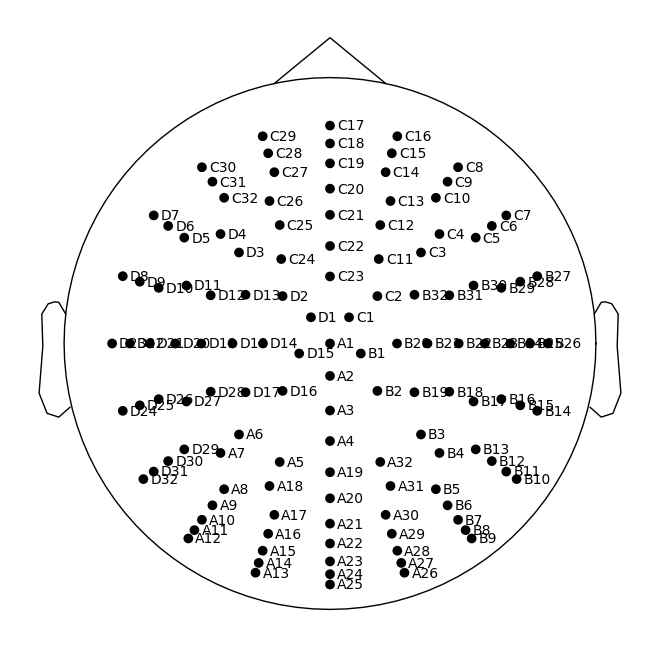

In [ ]:
montage = mne.channels.make_standard_montage('biosemi128')
eeg_run1.set_montage(montage);
mne.viz.plot_montage(montage);

In [ ]:
eeg_run1.plot?

Using matplotlib as 2D backend.


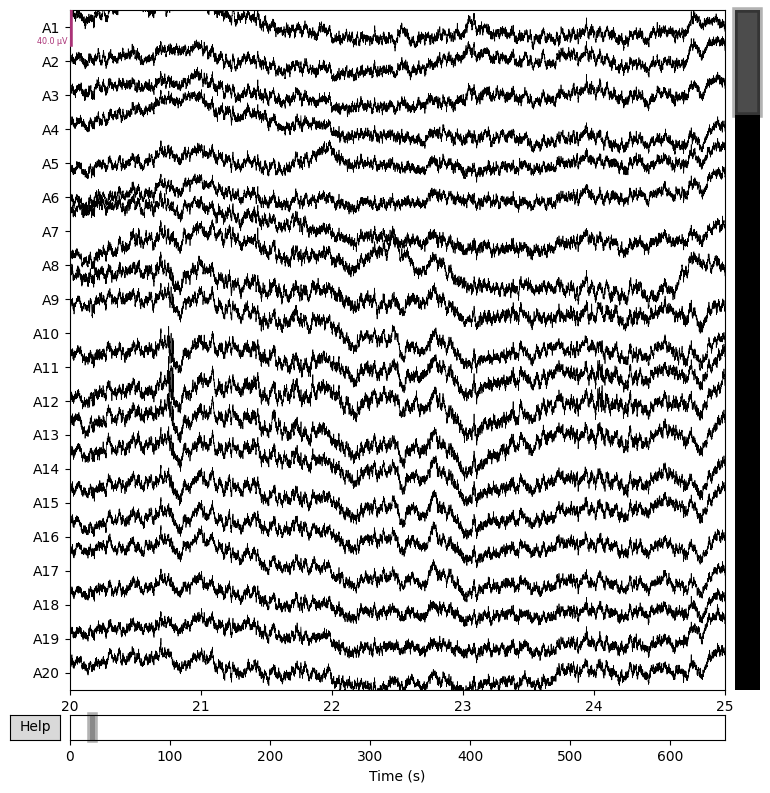

In [ ]:
eeg_run1.plot(start=20, duration=5);
# This doesn't show all 128 electrodes, but the top 20
# Different sets can be specified, but this function is really designed for the
# pop-out scrollable windows that don't work so well with code notebooks.

# Re-Referencing

The signals recorded by EEG are voltage differences between an electrode placed on the scalp and a reference electrode. The electrodes pick up many electrical disturbances and ideally you want a reference electrode that picks up everything that the scalp electrode picks up, except any neural activity. This means the difference between the signals purely reflects the electrical activity driven by the brain. Often reference electrodes are placed on the participant's body but not directly over the brain, but close to the head. Common places are the earlobes, or the mastoids. Some systems have a specific reference channel as part of the EEG cap setup. If the recording reference is placed on the scalp then the closest electrodes are likely to be more similar to the reference than more distant electrodes. Ideally, the reference should not be correlated with any of the electrodes used to record neural data. This motivates re-referencing to the common average. The average reference signal is taken to be the mean across all electrodes and this is subtracted from the entire recording. This removes spatial bias from electrodes that were in closer proximity to the reference electrode.

Read more about re-referencing in MNE [here](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html)

In [ ]:
eeg_run1.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | faces_run1.bdf, 129 x 1341440 (655.0 s), ~1.29 GB, data loaded>

## The Stimulus Channel

In EEG systems, continuous data is recorded for each electrode and for the most part 'electrode' is synonymous with 'channel', although 'channel' really just means a stream of temporally-changing data in the same data structure. When a participant, whose brain waves are being recorded, is presented with some stimuli from the experiment, the presentation computer sends a pulse of electricity to a non-EEG channel in the recording system to signal the timing of the presentation of the current stimulus.

This means identification codes in the stimuli channel are numerical and need to be converted at some point into human-readable labels (unless you just keep track of which number refers to which condition). In some other designs, the same trigger value is sent to the EEG recording channel and a separate log of the condition labels is kept and once we load the data into our preprocessing scripts, we can map this back again. That's what we will do in this case.

MNE is clever enough to know where to find a stimulis channel in the data and has a special function, `find_events` which, when passed EEG data, will look through the stimulus channel and find the timings and event codes and return a matrix of results. Let's call that function now and observe the output.

In [ ]:
events = mne.find_events(eeg_run1)

Trigger channel has a non-zero initial value of 130560 (consider using initial_event=True to detect this event)
172 events found
Event IDs: [65152]


To signal the start of recording in the case of any missed data close to the start of the recording session, a separate trigger value is sent to register that the 'begin' signal has been successfully recorded. We see this here (trigger value 130560), which we can ignore. MNE is clever enough to know that any single trigger (not repeated for the rest of the recording session) found in the first slot of the stimulus channel, is likely this begin signal. We are helpfully told that this has been ignored, but if it had actually been a stimulus trigger, we could easily also include it by passing in `True` to the `initial_event` parameter of `mne.find_events`.


In [ ]:
events[:5]

array([[15790, 65024, 65152],
       [23336, 65024, 65152],
       [30814, 65024, 65152],
       [38291, 65024, 65152],
       [45837, 65024, 65152]])

Each event has three different values associated with it. The first (first column) is the index in the EEG recording where it occurred. By knowing the sampling frequency that the EEG data was recorded with, this can easily be turned into the seconds from the start of the recording. The final column is the event code sent during the presentation of the stimulus (always 65152 in this case). We can ignore the the 2nd column. This column displays the event code value for the immediately preceding data sample and is often zero to signal the absence of a stimulus. For this dataset, absence of a stimulus is coded as '65024'. There's probably a technical reason for that, but it's not something we need to concern ourselves with today.

In [ ]:
# Remember, Python uses zero-indexing

third_event_onset = events[2][0]
sfreq = eeg_run1.info['sfreq'] # sampling frequency
third_event_in_seconds = third_event_onset / sfreq

print(f"The 3rd event happened at {third_event_in_seconds:.3f} seconds")

The 3rd event happened at 15.046 seconds


This dataset comes with a file called `condition_labels.txt`. Let's load & inspect it.

In [ ]:
label_file = EEG_folder / 'condition_labels.txt'
labels = label_file.read_text(encoding='utf-8')
labels = labels.splitlines()
print(f"Found {len(labels)} events")
print(labels[:5])

Found 172 events
['scrambled', 'faces', 'faces', 'scrambled', 'faces']


Note the number of events found in `condition_labels.txt` (172) matches the number of event triggers in the EEG stimulus channel (172).
Let's update the `events` data structure to reflect the encoding of faces vs scrambled. Note as this is a numerical matrix, we will still use numerical indices to mark the category of both normal face and scrambled face presentations.

In [ ]:
condition_map = {'faces': 0, 'scrambled': 1}
new_event_codes = [condition_map[label] for label in labels]

In [ ]:
new_event_codes[:5]

[1, 0, 0, 1, 0]

As a quality check, make sure these label indices match up with the first five text labels we displayed above. We can now update the third column of the `events` data structure.

In [ ]:
events[:, 2] = new_event_codes
events[:5]

array([[15790, 65024,     1],
       [23336, 65024,     0],
       [30814, 65024,     0],
       [38291, 65024,     1],
       [45837, 65024,     0]])

## Filtering

EEG data contains many high-frequency components that are not related to neural signals and need to be account for during preprocessing. We are typically only interested in signals ranging from 0 Hz to 100 Hz (often not even as high as that) as this is the range of the frequency spectrum where neural signals exist. Recent work on high-gamma activity (variously defined, but can be upper bounded around 200 Hz, though many consider the higher-end bound to be considerably lower. By filtering from slightly higher than 0 (typically 0.1 - 1 Hz), we can remove low-frequency drifts from the EEG recording, which is desirable for purposes of *stationarity*. Another major component is electrical noise. The frequency of electrical noise various across the world. In the US & Canada, it's at 60 Hz, while in Europe it is at 50 Hz. You should always consider where datasets were recorded, for this reason, and plot the Power Spectral Density (PSD) of the signal to detect peaks that reflect the mains electrical noise. It's not enough to put in a fixed value in a notch filter (to remove a small area around the frequency band of the electrical noise) because you might not be selecting the correct value.

In Japan, the situation is even more critical because Eastern Japan uses 50 Hz electrical frequency while Western Japan uses 60 Hz.
Let's compute the PSD of our loaded EEG data.

Effective window size : 1.000 (s)


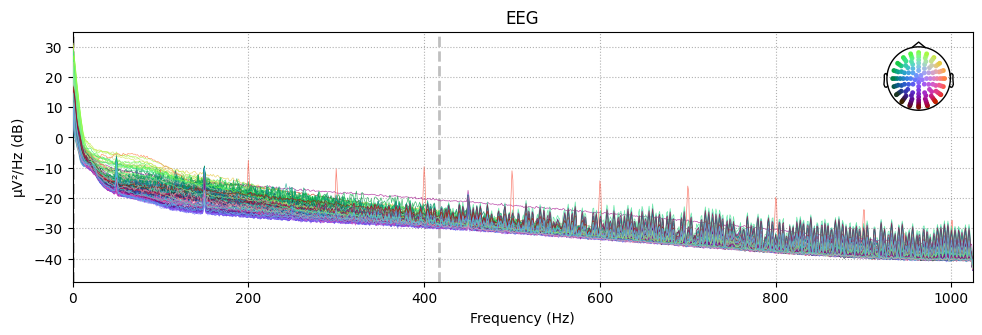

In [ ]:
eeg_run1.compute_psd().plot();

Let's zoom in a little bit on the region we are most interested in (0-100 Hz).

Effective window size : 1.000 (s)


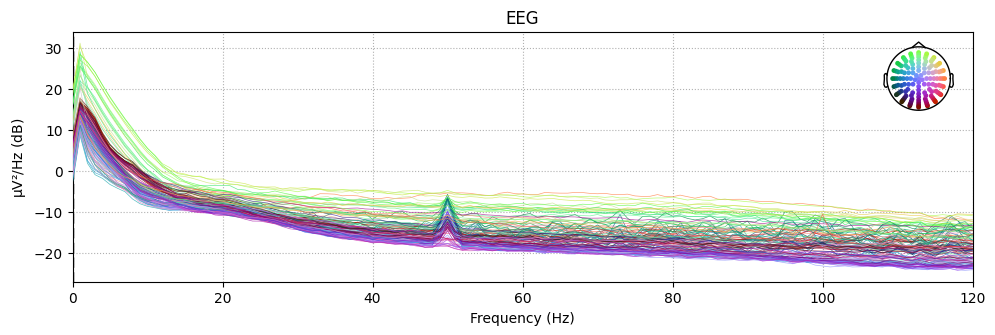

In [ ]:
eeg_run1.compute_psd(fmax=120).plot();

Do you see the spike around 50 Hz? Now you know what part of the world this data was recorded (Europe or Eastern Japan!)

Let's filter the EEG data to our desired frequency spectrum range.

In [ ]:
#eeg_run1.load_data()
eeg_run1_filtered = eeg_run1.copy().filter(l_freq=0.01, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 675841 samples (330.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   31.8s


We will now observe the effect of our filtering by re-computing the PSD of the signal. You should see a drop off shortly above the top end of the frequency band we allowed.

Effective window size : 1.000 (s)


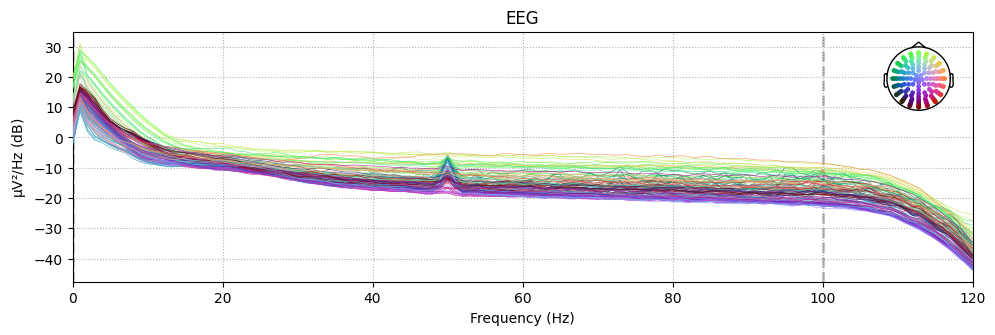

In [ ]:
eeg_run1_filtered.compute_psd(fmax=120).plot();

We will now apply a notch filter to take out the 50 Hz compomnent due to electrical noise.

In [ ]:
eeg_run1_filtered = eeg_run1_filtered.notch_filter(freqs=50)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.0s


Effective window size : 1.000 (s)


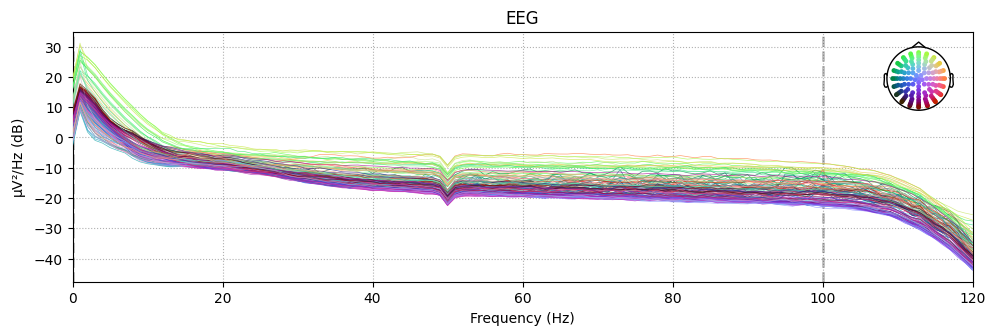

In [ ]:
eeg_run1_filtered.compute_psd(fmax=120).plot();

The effect of filtering out this signal can still be seen, but the effect of electrical noise at this frequency has been removed.

## Epoching

An epoch in neural data analysis is different from an epoch in machine learning. In machine learning, an epoch is one full pass through the training data, but in neural data analysis it means a selected time window around a stimulus onset. If a scrambled face was presented at 375 seconds into an experiment, then for that specific image, we would want to capture the recorded neural response afterwards. The size of the window that we take defines the length of the epoch. An `Epoch` is also a specific data structure in MNE. Up to now, we have been working with a `Raw` object.

In [ ]:
type(eeg_run1_filtered)

mne.io.edf.edf.RawEDF

In order to define the window of data around the onset of the face or scrambled-face presentations, we will use the `tmin` and `tmax` parameters of `mne.Epochs`.

In [ ]:
epochs = mne.Epochs(eeg_run1_filtered, events, tmin=-0.1, tmax=0.7, picks=eeg_channels)

Not setting metadata
172 matching events found
Setting baseline interval to [-0.10009765625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [ ]:
epochs

Number of events,172
Events,0: 861: 86
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


Why did we extract information **before** the images were presented? Notice the bottom row labelled 'baseline'. The baseline period is important in EEG because the voltages recorded from the scalp can fluctuate quite a lot over time, rising and falling, and it's not enough to simply high-pass filter to remove low-frequency drifts. If we are comparing events where a participant saw images over a long recording session, we don't want the recorded data at the end of the session to be on a different scale to recorded data at the start of the recording session. We typically use the baseline period as a way to correct for any other drifts so that at the onset of the stimulus, everything is zero centred. We take, for each electrode, what was going on in the baseline period (here: 100 ms / 0.1 s) and take the average value. We do this for all electrodes independently. Then for the entire epoch (the 700 ms / 0.7 s we specified in our case) we subtract the averaged values found in the baseline period. This is an important step and something to watch out for if you suspect your results are incorrect.

You can always check whether your `mne.Epochs` data structure has an associated baseline period with the following:

In [ ]:
epochs.baseline

(-0.10009765625, 0.0)

MNE likes to keep the baseline interval around and apply it on-the-fly whenever it is needed. However, that's not always necessary and an explicit call to `epochs.apply_baseline` will apply the baseline correction so we can discard the baseline EEG data. This operation cannot be undone, so if your code takes a long time to process from loading the initial raw data, it's best to wait until all code issues have been solved if you want to call this function.

Before, we had a separate `events` array floating around that we calculated from `mne.find_events` but since we included it in the constructor to the `Epochs` object, this is now a member variable of `epochs`. Now we are in a position to replace the event id mapping to use our human-readable labels for easy analysis later.

In [ ]:
epochs.events.shape # This is where the events info is stored now

(172, 3)

In [ ]:
epochs.event_id

{'0': 0, '1': 1}

We want this to be replaced by the mapping we created earlier:

In [ ]:
condition_map

{'faces': 0, 'scrambled': 1}

So we overwrite it:

In [ ]:
epochs.event_id = condition_map
epochs.event_id

{'faces': 0, 'scrambled': 1}

## Downsampling

Downsampling is an operation where you reduce the temporal precision of your data. The sampling frequency of this raw EEG data is 2,048 Hz (2,048 time points per second). This is very fast (most EEG systems record with a max of 1,000 Hz). For our purposes, we can reduce the data size much further by downsampling the data to 250 Hz.

In [ ]:
epochs.load_data()
epochs_rs = epochs.resample(sfreq=250)

Using data from preloaded Raw for 172 events and 1640 original time points ...
0 bad epochs dropped


In [ ]:
epochs_rs.info['sfreq']

250.0

## Let's Recap

We have:
* Loaded raw data
* Extracted events
* Defined which channels contained EEG data
* Filtered the signals
* Extracted epochs
* Downsampled

What does the data look like now? We know we have 172 events, but let's explore the shapes to make sure everything is clear.

In [ ]:
print(f"Number of events: {epochs.events.shape[0]}")

Number of events: 172


In [ ]:
n_faces     = sum((epochs.events[:,2] == 0).astype(np.int8))
n_scrambled = sum((epochs.events[:,2] == 1).astype(np.int8))

print(f"There are {n_faces} face presentations and {n_scrambled} scrambled-face presentations")

There are 86 face presentations and 86 scrambled-face presentations


Now let's look at the EEG data itself.

In [ ]:
epochs._data.shape

(172, 128, 200)

The actual signal values are contained in `epochs._data`. A single underscore preceding a member variable is a suggestion from the authors that this isn't something to be used or manipulated directly, but other functions / functionality uses this data. However, you're all almost experts at EEG analysis now so this is fine :)

We have 172 events, each one takes up a place in the first dimension. There are 128 electrodes in our dataset (this was mentioned at the beginning) and we have 200 time points per channel. If you remember, we set `tmin=-0.1` and `tmax=0.7`. This means we have 100 ms pre-stimulus and 700 ms post-stimulus. Our new sampling rate is 250 Hz, so this all works out. When MNE applies further preprocessing steps, it is fully aware of the baseline period.

**However**, if you were to extract EEG data in this format to NumPy for ML / DL algorithms elsewhere, you must be aware of this as you need to factor in consideration of the baseline period unless you specifically want to include it in your analyses.

In [ ]:
epoch_length_s = epochs._data.shape[2] / epochs.info['sfreq']
epoch_length_ms = epoch_length_s * 1000

print(f'The epoch window is {epoch_length_ms} milliseconds')

The epoch window is 800.0 milliseconds


## Averaging

One common step when we reach this point is to average together all the trials across the two conditions and plot their activity. Let's do that. In order to do that, we simply need to call the `.average()` method on an `mne.Epochs` data structure. This results in an `mne.Evoked` data structure. This terminology is a bit of a carry-over from the cognitive neuroscience literature. Just know that it refers to averaged epochs.

In [ ]:
faces_avg = epochs['faces'].average()
scrambled_avg = epochs['scrambled'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


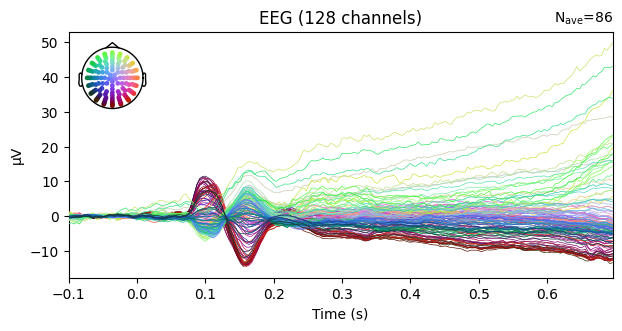

In [ ]:
faces_avg.plot(spatial_colors=True);

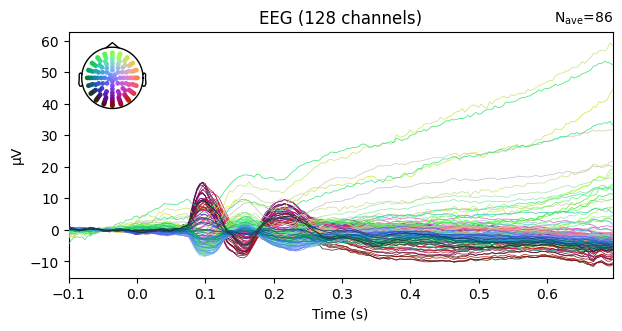

In [ ]:
scrambled_avg.plot(spatial_colors=True);

Notice the top right refers to the number of individual trials that go into the average. Notice on the x-axis that the baseline interval is included and is centred at zero. This is because we subtracted the mean signal in this period from the entire epoch.

These plots look quite similar at a first glance, but there are aspects that look to be a bit different upon closer inspection. What we need is a way to look at the difference between them, one subtracted from the other.

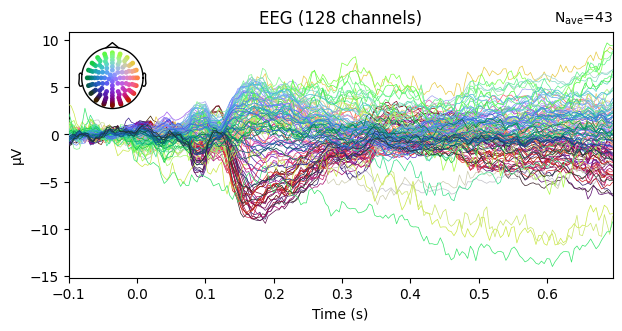

In [ ]:
faces_vs_scrambled = mne.combine_evoked([faces_avg, scrambled_avg], weights=[1,-1])
faces_vs_scrambled.plot(spatial_colors=True);

This plot reflects the result of taking EEG activity after seeing a face and subtracting from it the EEG activity after seeing a scrambled face. These two conditions are well-matched in terms of visual information on the screen. The difference lies in the organisation (the state of not being scrambled) of one condition into what we recognise as faces. If the brain responded the same way to both conditions, in the subtraction paradigm, the results would be around zero. This is not the case here.


This means that (if you apply a little mental algebra) that the face response must be more negative in the N170 time period, while the scrambled face condition is less negative (because faces were not registered). This means there is a net negative effect in response to faces when the scrambled condition is subtracted from the unscrambled version.

Which electrodes show this result? What do the colours tell you? Is it what you would expect?

Let's dive in a little further and take the opportunity to demonstrate the `plot_joint` function in MNE.

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


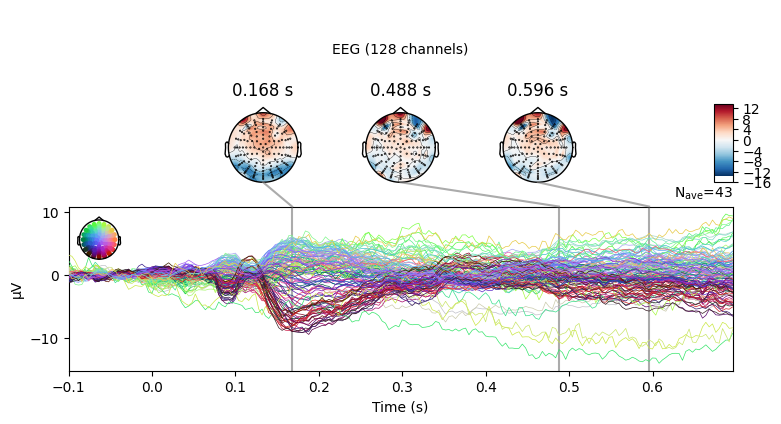

In [ ]:
faces_vs_scrambled.plot_joint();

The `plot_joint` function takes many more options and is much more customisable. Because we're primarily interested more in the temporal period between 150-300 ms, let's specify that we want to see more scalp distributions from that time period, and cut off some of the later time periods to unclutter the visualisation.
Specifically, we'll:
* Copy the `Evoked` object so we can crop it and not lose the original data
* Apply cropping to the copy, specifying the window with `tmin` and `tmax` (in seconds)
* Specify a series of times, i.e. `times=[0.1, 0.15, 0.17, 0.2, 0.25]` and passing this to `plot_joint`

We could also pass many options to style the figure. Check out the documentation for this function if you want to learn more.
It should be even clearer now the occipital regions are driving this effect. If you didn't already know from class, the Fusiform Face Area is a very posterior functional area. Do you think this area is driving the effect?

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


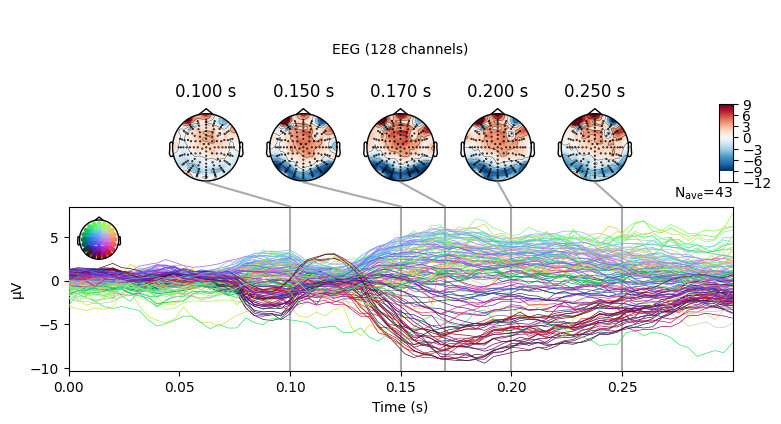

In [ ]:
faces_vs_scrambled.copy().crop(tmin=0.0, tmax=0.3).plot_joint(times=[0.1, 0.15, 0.17, 0.2, 0.25]);

Now we have visually inspected the data, let's see if we can train a classifier to detect this difference. It's worth stating here again that for this example, we are studying a well-known electrical response to faces, where differences in conditions can be seen by the eye. In many applications you might want to use machine learning, it would be the classifier's goal to try to detect differences between conditions, ones which the human eye can't see easily or reason about. Advanced modern deep neural networks can analyse the nonlinear combinations and complicated temporal relations in order to provide evidence or clues that can point researchers into new directions.

## Training a Classifier

You are free to use whichever tool that you like to apply machine learning to neural data. I will provide a `scikit-learn` model in this example, since we are learning from limited data here (86 examples in a balanced binary classification paradigm). The first step is to decide what the data is that will be input to the model. We can use background knowledge to guide us in this case (most of the time we are not so lucky) and so I will consider the temporal signals between 100 ms & 300 ms

The code blocks below are taken from here (with some irrelevant lines removed) and with slight editing:
* https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html


We just need to create an `X` matrix and `y` vector, namely the data matrix and the associated labels. We'll do this now.

In [ ]:
X = epochs.get_data()[:,:,:]
y = epochs.events[:,2] # labels in the 3rd column, remember

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.decoding import (
    SlidingEstimator,
    cross_val_multiscore,
    Scaler,
    Vectorizer
)


clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=3, n_jobs=None)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print("Final Score: %0.1f%%" % (100 * score,))

Final Score: 82.6%


We achieve 82% accuracy - not bad!

Note here we're using all the data in the epoch. We know there is a strong effect localised within the 100 ms - 300 ms time window. An issue we will see here is that including a lot of extra information without care to how its inclusion affects the classification performance can lead to lower scores than a more well-considered feature selection stage (here: reducing the number of data points).

Let's make `X2`, a copy of `X` but that only contains information from 100 - 300 ms.

In [ ]:
# 25 samples = 100 ms
X2 = epochs.get_data()[:,:,50:100]

In [ ]:
scores = cross_val_multiscore(clf, X2, y, cv=3, n_jobs=None)
score = np.mean(scores, axis=0)
print("Final Score: %0.1f%%" % (100 * score,))

Final Score: 88.4%


The top decoding score jumped up to 88%, a difference of almost 6% points. It's a matter of experimentation when it comes to feature selection for smaller models (bigger models can learn to ignore irrelevant data more easily). Another dimension of feature extraction, beyond selecting the temporal window of EEG data to include, is the subset of electrodes. We saw earlier that posterior electrodes had the largest effect on detecting faces over scrambled-faces. Reducing the number of channels to only include posterior electrodes might further boost this accuracy higher.

Next, we'll look at Temporal Decoding.

### Temporal Decoding

We have seen what happens when we include all available data (score = 82%) and the effect that reducing this to a sensible window had (score = 88%). If we go too far the other way, we might not have enough features together to represent a good solution to do any decoding. However, with clear effects, this is not the case. In such cases, we can build a model at every individual time point and run the same model. This is one of the reasons we performed downsampling earlier. We don't want to run 2,048 cross-validations when we can extract a clear pattern with just 200 models instead. By creating models at every individual timepoint, we can pinpoint when signal becomes available to be useful in solving the classification problem. This is a great help to interpret the inner workings of the representational / information content of the neural signals we are working with.

MNE has good pre-defined functionality for many of these cases. In this case, we will make use of `SlidingEstimator` (again with a `LogisticRegression` classifier).

  0%|          | Fitting SlidingEstimator : 0/200 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/200 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/200 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Face vs Scrambled - Temporal Decoding')

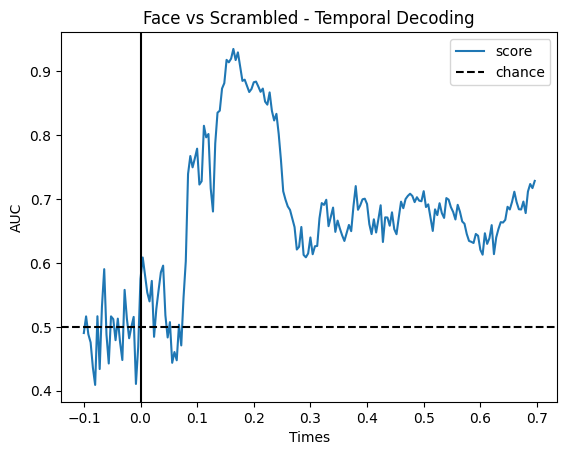

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Face vs Scrambled - Temporal Decoding")

Chance accuracy is 50% / 0.5 and by only using single timepoints, we assess the capability of the classifier to decode the correct stimulus being perceived using cross-validation and the AUC (Area Under Curve) metric to assess classifier performance. We use a Logistic Regression classifier (nice because it has no hyperparams to fit and works well on neural data). Also note we included a `StandardScaler` instance in the preprocessing, as this is a necessary step.

The peak decoding accuracy occurs between 150 ms and 250 ms, which is entirely expected since we are aware of the N170 effect. Curiously, we still see higher scores after the end of the peak (after 300 ms). What is going on here? Why do you suspect we can still decode faces vs scrambled faces up to 700 ms after visual presentation?

## Things I Left Out

* Independent Components Analysis (ICA)

ICA is a data cleaning technique and is used to remove noise signals from neural data. The application of it requires a bit of background knowledge and experience in interpreting the plots. At the time of writing, the electrode locations aren't loading correctly so this can't be applied and is another reason I have not included it. This is why you see some wavy spikes in some of the plots. There are other ways to get rid of those.

* Data Quality checks

MNE has various functionality to check for bad channels (channels that were not connected to the head and mostly consist of noise) and excessive noise in epochs that clears up signals well. This is most important for cognitive neuroscience research where interpretability and visualisation is key. Many people now say that for downstream machine learning applications, capable models are able to ignore such issues, provided there are enough samples to learn from. To learn more about handing bad channels in MNE, see this link: https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html

* Band-pass Filtering

Various cognitive phenomena have been studied in EEG and are known to exist in specific frequency bands (alpha, beta, theta, gamma, delta etc.) and a pre-processing step that derives these features is often seen in this sort of analysis. Here we just used the broadband signal (we didn't narrow-band it to extract a specific frequency component). This might be something you want to consider in your projects. Check out the MNE documentation to see examples of how this is done

* Connections to Deep Learning

This would have required a lot more data to get working well but I also didn't want to give you too much. Part of the adventure is being curious and trying to write your own code or exploring the documentation. Many proposals will be connected to larger neural networks, but this notebook gives you the steps to go from raw data to a NumPy-suitable representation that you can apply in any further library.

## End of Part 1